In [1]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
import nltk
import boto3
from botocore.exceptions import ClientError
import os
import json
import pymorphy2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
import word2vec

In [2]:
twitter_data = pd.read_csv("input_data/Corona_NLP_train.csv", encoding = "ISO-8859-1")
twitter_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
list_of_all_tweets = list(twitter_data['OriginalTweet'])

Для начала немного преподготовим наши данные, и объеденим Extremely Negative с Negative  
и Extremely Positive с Positive

In [4]:
twitter_data.loc[twitter_data.Sentiment == 'Extremely Negative', 'Sentiment'] = 'Negative'
twitter_data.loc[twitter_data.Sentiment == 'Extremely Positive', 'Sentiment'] = 'Positive'

twitter_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative


1) Очистить данные от "мусора" - хэштегов, ссылок, запятых, точек и прочего.  

In [5]:
def clean(data):
    res = []
    for i in range(0, len(data)):
        temp = data[i]
        temp = re.sub("@\S+", " ", temp)
        temp = re.sub("https*\S+", " ", temp)
        temp = re.sub("#\S+", " ", temp)
        temp = re.sub("\'\w+", '', temp)
        temp = re.sub('[%s]' % re.escape(string.punctuation), ' ', temp)
        temp = re.sub(r'\w*\d+\w*', '', temp)
        temp = re.sub('\s{2,}', " ", temp)
        list_of_temp = temp.split(" ")
        out = []
        for temp in list_of_temp:
            if not temp.isalpha():
                continue
            if temp == '':
                continue
            else:
                out.append(temp.lower())
        temp = ' '.join(out)
        res.append(temp)
    return res

In [6]:
out = clean(list(twitter_data['OriginalTweet']))

Создадим новый датасет, с которым и будем работать в будущем.  
Для определения тональности текста нам не понадобятся username, ScreenName, Location, TweetAt

In [7]:
clean_twitts = pd.DataFrame()

clean_twitts['OriginalTweet'] = out
clean_twitts['Sentiment'] = twitter_data['Sentiment']

clean_twitts.head()

,OriginalTweet,Sentiment
0,and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,me ready to go at supermarket during the outbr...,Negative


2) Найти эмоциональный окрас с помощью сервиса Amazon Comprehend

In [8]:
# Посмотрим какие классы у нас вообще есть
list_of_labels = list(clean_twitts['Sentiment'].unique())
list_of_labels

['Neutral', 'Positive', 'Negative']

In [9]:
# функция разделяет твитты по классам и записывает их в файл, нужно мне для анализа в amazon comprehend
def get_twitts(twitter_data, label, filename):
    l = twitter_data[twitter_data.Sentiment == label]
    l = list(l['OriginalTweet'])
    
    f = open(f"{filename}.txt", "w")
    for twitt in l[0:int(len(l)/10)]:
        f.write(twitt + "\n")
    f.close()

In [10]:
# создадим файл для каждого класса
# в результате у нас есть три файла
# в каждом файле-классе только твитты относящиеся к этому классу
for label in list_of_labels:
    get_twitts(clean_twitts, label, label)

Далее а Amazon Comprehend я для каждого файла сделала анализ на Sentiment, по строчно.  
Так как у меня в каждом файле хранятся твитты (разделенные новой строкой), относящиеся только к классу с названием файла, метрику accuracy можно посчитать следующим образом

In [11]:
def get_accuracy(filename, clean=False):
    jsons = []
    with open(filename) as f:
        for line in f:
            jsons.append(json.loads(line))
    
    score = 0
    for j in jsons:
        # сравниваю название файла с предсказаной тональностью (должны совпадать)
        original_sentiment = j['File'].split(".")[0].lower()
        if clean:
            original_sentiment = original_sentiment.split("_")[0]
        pred_sentiment = j['Sentiment'].lower()
        if original_sentiment == pred_sentiment:
            score += 1
                        
    return score / len(jsons) * 100

Как мы видим с помощью амазон сервиса мы получили крайне низкий результат accuracy  
Лишь немного выше чем рандомный выбор с вероятностью угадать 1/3

In [12]:
accuracy = get_accuracy("input_data/sentiment_from_comprehend.txt")
print(f"Accuracy = {accuracy}%")

Accuracy = 39.499270782693245%


Нормализовать данные и снова посмотреть на окрас с помощью Amazon Comprehend  

Теперь попробуем всё тоже самое, только удалим стоп-слова и преобразуем все слова в начальную форму.  
Для этого создадим ещё один датафрейм, потому что тот нам еще понадобится

In [14]:
# преобразуем в начальную форму и удаляем стоп-слова

list_of_twitts = list(clean_twitts['OriginalTweet'])
out_list = []

morph = pymorphy2.MorphAnalyzer(lang='uk')

for twitt in list_of_twitts:
    # удаляем стоп-слова
    filtered_words = [word for word in twitt.split(" ") if word not in stopwords.words('english')]
    # преобразуем в начальную форму
    normal_form_words = []
    for word in filtered_words:
        normal_form_words.append(morph.parse(word)[0].normal_form)
    # объединяем
    out_list.append(' '.join(normal_form_words))

In [15]:
clean_and_normal = pd.DataFrame()

clean_and_normal['OriginalTweet'] = out_list
clean_and_normal['Sentiment'] = twitter_data['Sentiment']

clean_and_normal.head()

,OriginalTweet,Sentiment
0,,Neutral
1,advice talk neighbours family exchange phone n...,Positive
2,coronavirus australia woolworths give elderly ...,Positive
3,food stock one empty please panic enough food ...,Positive
4,ready go supermarket outbreak paranoid food st...,Negative


In [17]:
# создадим такие же файлы как и раньше
for label in list_of_labels:
    get_twitts(clean_and_normal, label, label + '_cleanup')

3.1) Сравнить полученные результаты  
Далее всё тоже самое с Amazon Comprehend  
Как можно наблюдать точность уменьшилась, что меня несколько удивило

In [18]:
accuracy = get_accuracy("output", True)
print(f"Accuracy = {accuracy}%")

Accuracy = 31.186193485658727%


Теперь попробуем написать что-то своё

In [16]:
# нам нужна функция которая посчитает метрику accuracy схожим способом что и раньше
def get_accuracy_from_list(real, predictions):
    score = 0
    for i in range(len(real)):
        if real[i] == predictions[i]:
            score += 1
    return score / len(real) * 100

Далее поделим наши данные на тестовую и обучающие выборки, сначала для данных, очищенных только от хэштегов, ссылок и прочего

In [34]:
X_train, X_test, y_train, y_test = train_test_split(clean_twitts['OriginalTweet'], clean_twitts['Sentiment'], test_size=0.2, random_state=42)

4) Векторизовать датасет  
Преобразуем данные в вектор

In [18]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

In [19]:
train_data_features = vectorizer.fit_transform(list(X_train)).toarray()

5) Проверить точность предсказаний с помощью RandomForest и LogisticRegression  

In [51]:
scores = cross_val_score(LogisticRegression(), train_data_features, y_train, cv=5)

Как можно наблюдать даже простая логистическая регрессия справилась с нашей задачей куда лучаше

In [52]:
print("Accuracy: {:.2f}".format(np.mean(scores)))

Accuracy: 0.79


Всё тоже самое, только для нормализованных данных

In [37]:
X_train, X_test, y_train, y_test = train_test_split(clean_and_normal['OriginalTweet'], clean_and_normal['Sentiment'], test_size=0.2, random_state=42)
train_data_features = vectorizer.fit_transform(list(X_train)).toarray()
scores = cross_val_score(LogisticRegression(), train_data_features, y_train, cv=5)

In [54]:
print("Accuracy: {:.2f}".format(np.mean(scores)))

Accuracy: 0.79


С RandomForest

In [55]:
train_data_features = vectorizer.fit_transform(list(X_train)).toarray()
scores = cross_val_score(RandomForestClassifier(n_estimators = 200), train_data_features, y_train, cv=5)
print("Accuracy: {:.2f}".format(np.mean(scores)))

Accuracy: 0.74


6) Посмотреть самые частые встречающиеся слова в твиттах  


In [20]:
most_frequent = dict()

for tweet in out_list:
    words = tweet.split(' ')
    for word in words:
        if most_frequent.get(word) is None:
            most_frequent[word] = 1
        else:
            most_frequent[word] += 1

In [36]:
len(most_frequent)

32034

Посмотрим на самые частые слова в наших твиттах  
Как и было ожидаемо самым частым словом в твиттах про коронавирус, стало слово коронавирус...

<AxesSubplot:title={'center':'The most frequent words'}>

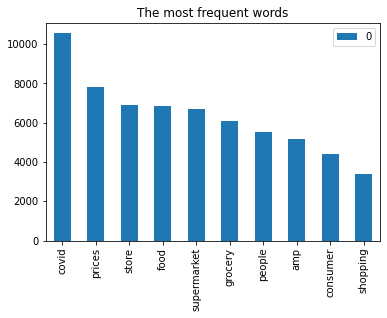

In [78]:
most_frequent = dict(sorted(most_frequent.items(), key=lambda x: x[1], reverse=True))
pd.DataFrame.from_dict(most_frequent, orient='index').head(10).plot.bar(title='The most frequent words')

In [22]:
all_words = []
for tweet in out_list:
    words = tweet.split(' ')
    for word in words:
        all_words.append(word)

In [23]:
all_words = nltk.FreqDist(all_words)

In [24]:
all_words

FreqDist({'covid': 10545, 'prices': 7841, 'store': 6878, 'food': 6859, 'supermarket': 6692, 'grocery': 6094, 'people': 5547, 'amp': 5187, 'consumer': 4402, 'shopping': 3367, ...})

7) Токенизировать твитты  

In [68]:
train = []
y_list = list(y_train)

for i, X in enumerate(list(X_train)):
    train.append((X, y_list[i]))
    
train = train[:5000]

In [69]:
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
import time

start = time.time()

all_words = set(word.lower() for passage in train for word in word_tokenize(passage[0]))
t = [({word: (word in word_tokenize(x[0])) for word in all_words}, x[1]) for x in train]

end = time.time()

In [70]:
end - start

6670.435631752014

8) Посмотреть самые информативные слова  

In [71]:
classifier = nltk.NaiveBayesClassifier.train(t)
classifier.show_most_informative_features()

Most Informative Features
                  demand = True           Negati : Neutra =     40.8 : 1.0
                   thank = True           Positi : Neutra =     27.1 : 1.0
                   panic = True           Negati : Neutra =     22.8 : 1.0
                    good = True           Positi : Neutra =     22.0 : 1.0
                 support = True           Positi : Neutra =     21.4 : 1.0
                    fear = True           Negati : Positi =     20.5 : 1.0
                    stop = True           Negati : Neutra =     19.4 : 1.0
                    care = True           Positi : Neutra =     18.5 : 1.0
                    scam = True           Negati : Positi =     14.9 : 1.0
                    safe = True           Positi : Neutra =     14.8 : 1.0


9) Сделать предсказания с помощью NaiveBayesClassifier и посмотреть точность  

In [75]:
y_test_list = list(y_test)[:300]
c = 0
for i, test in enumerate(list(X_test)[:300]):
    test_sent_features = {word: (word in word_tokenize(test.lower())) for word in all_words}
    class_is = classifier.classify(test_sent_features)
    if class_is == y_test_list[i]:
        c += 1

In [76]:
accuracy = c / len(y_test_list) * 100        
print(f"Accuracy = {accuracy}%")

Accuracy = 64.33333333333333%


Как можно наблюдать самая высокая точность определения эмоционального окраса получилась у метода векторизации текста с последующим применеием логистической регрессии или же случайного леса.  
Но последний метод, мог бы показать гораздо лучший результат, если бы выборка была больше. В данном случае я взяла 5000 твиттов, так как процес токенезации даже такого малого количества твиттов занял почти 2 часа.  
Больше всего меня разочаровал Amazon, я надеялась получить там куда большую точность в предсказаниях. Я думаю, что это произошло потому что твитты о коронавирусе несколько специфичны и для определения окраса нужна оюучающая выборка именно таких твиттов.